In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
import sklearn.linear_model as slm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import func_stats as fs
import sys
import copy
import warnings
warnings.filterwarnings("ignore")

/Users/binwanadmin/software/miniconda3/envs/autism/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
import func_plot as fp
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69
lh, rh = load_conte69()

glasser = np.genfromtxt('../data/glasser.csv')
glasser_l = glasser[:32492]
glasser_r = glasser[32492:]
glasser_r[glasser_r==180]=0
glasser = np.concatenate((glasser_l,glasser_r))
mask = glasser != 0

In [3]:
def cov_rm(cov, feature):
  GLM = slm.LinearRegression()
  GLM.fit(X=cov, y=feature) # fit model
  rest = np.zeros((feature.shape))
  for s in range(feature.shape[1]):
    rest[:,s] = np.sum(GLM.coef_[s] * cov, axis=1) # sum cov contribution
  return feature - rest # minus cov contribution

In [4]:
# script parameters:
sample = 100
#out_phen = 'psy'
feature = pd.read_csv('../hcp/solar/intensity_asy_total/1_phen.csv')
data_feature = np.array(feature)[:,3:].astype(float)
covs = np.array([feature.Age,feature.Gender])
covs[covs=='M'] = 1
covs[covs=='F'] = 0

outcome_lan = pd.read_csv('../hcp/unrestricted_wanb_9_14_2020_7_53_51.csv')
outcome_psy = pd.read_csv('../hcp/RESTRICTED_wanb_9_29_2020_2_14_36.csv')

In [5]:
mask_lan = np.zeros(1206)
mask_psy = np.zeros(1206)
for i in range(1206):
    if outcome_lan['Subject'][i] in np.array(feature['ID']):
        mask_lan[i] = 1
    if outcome_psy['Subject'][i] in np.array(feature['ID']):
        mask_psy[i] = 1
    
outcome_lan = outcome_lan[np.logical_and(mask_lan==1,mask_psy==1)].reset_index()
outcome_lan = outcome_lan[outcome_lan.columns[1:]]
outcome_psy = outcome_psy[np.logical_and(mask_lan==1,mask_psy==1)].reset_index()
outcome_psy = outcome_psy[outcome_psy.columns[1:]]

mz_class_org=np.loadtxt('../hcp/MZ_class.txt', delimiter=',')
mz_class=np.zeros(len(feature))
for i in range(len(feature)):
  if mz_class_org[:,1][mz_class_org[:,0].astype(int) == int(feature['ID'][i])] == 1:
    mz_class[i] = 1

In [6]:
pheno = pd.DataFrame()
pheno['Sex'] = outcome_lan.Gender
pheno['Sex'][pheno['Sex']=='M'] = 1
pheno['Sex'][pheno['Sex']=='F'] = 0
pheno['Age'] = outcome_psy.Age_in_Yrs
pheno['Reading'] = outcome_lan.ReadEng_AgeAdj
pheno['PicVocab'] = outcome_lan.PicVocab_AgeAdj
#pheno['ProcSpeed'] = outcome_lan.ProcSpeed_AgeAdj
pheno['Depression'] = outcome_psy.DSM_Depr_T
pheno['Depression'][pheno['Depression']<50] = np.nan
pheno['Anxiety'] = outcome_psy.DSM_Anxi_T
pheno['Anxiety'][pheno['Anxiety']<50] = np.nan
pheno['Somatic'] = outcome_psy.DSM_Somp_T
pheno['Somatic'][pheno['Somatic']<50] = np.nan
pheno['Avoidant'] = outcome_psy.DSM_Avoid_T
pheno['Avoidant'][pheno['Avoidant']<50] = np.nan
pheno['ADHD'] = outcome_psy.DSM_Adh_T
pheno['ADHD'][pheno['ADHD']<50] = np.nan
pheno['Antisocial'] = outcome_psy.DSM_Antis_T
pheno['Antisocial'][pheno['Antisocial']<50] = np.nan
mask_nan = ~pheno.isna().any(axis=1)

In [7]:
cca = CCA(n_components=1)
x = cov_rm(np.array(pheno)[mask_nan][:,:2], feature = data_feature[mask_nan])
y_psy = np.array(pheno)[mask_nan][:,4:]
y_lan = np.array(pheno)[mask_nan][:,2:4]
model_psy = cca.fit(x,y_psy)
cca = CCA(n_components=1)
model_lan= cca.fit(x,y_lan)
x_t_psy, y_t_psy = model_psy.transform(x, y_psy)
x_t_lan, y_t_lan = model_lan.transform(x, y_lan)

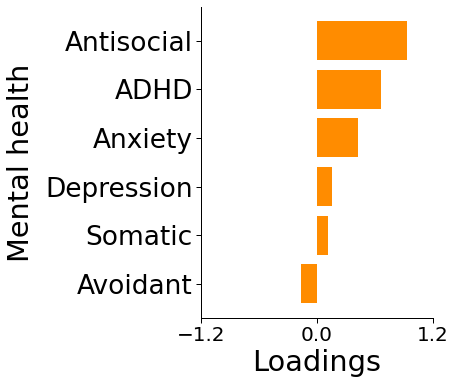

In [8]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(7,6))
fp.plot_t_single_h(-model_psy.y_loadings_[:,0], bar=None, ax=ax, ascend=True,x_axis=True, thres=1.2, color='darkorange',
                   y_name=np.array(['Depression', 'Anxiety','Somatic','Avoidant', 'ADHD','Antisocial']))
ax.set_ylabel('Mental health',labelpad=10)
ax.set_xlabel('Loadings')
plt.xticks(fontsize=20)
fig.tight_layout()
fig.savefig('../figures/hcp/cca_total_psy_bar.png', dpi=300, transparent=True)

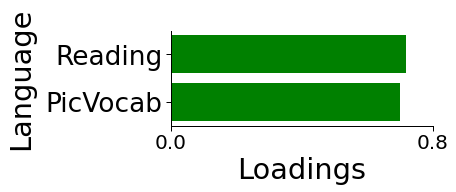

In [9]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(figsize=(7,3))
fp.plot_t_single_h(-model_lan.y_loadings_[:,0], bar=None, ax=ax, ascend=True, x_axis=True, thres=0.8, color='green',
                   y_name=np.array(['Reading', 'PicVocab','ProcSpeed']))
ax.set_ylabel('Language',labelpad=10)
ax.set_xlabel('Loadings')
plt.xticks(fontsize=20)
fig.tight_layout()
fig.savefig('../figures/hcp/cca_total_lan_bar.png', dpi=300, transparent=True)

((0.44602473652403235, 1.128309421422731e-53),
 (0.4894614372023147, 7.639506802814e-66))

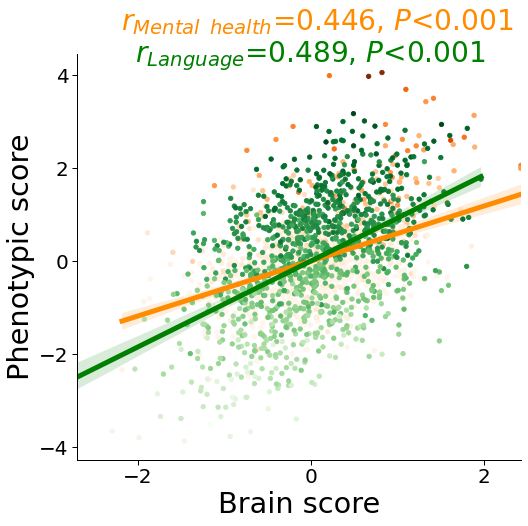

In [10]:
y1=-y_t_psy[:,0].copy()
y2=-y_t_lan[:,0].copy()
x1=-x_t_psy[:,0].copy()
x2=-x_t_lan[:,0].copy()
rp1 = ss.pearsonr(x1, y1)
rp2 = ss.pearsonr(x2, y2)
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(x1, y1, ax = ax, 
            scatter_kws={'s': 0, 'color': 'darkorange'},
            line_kws={'lw': 5, 'color': 'darkorange'})
sns.regplot(x2, y2, ax = ax, 
            scatter_kws={'s': 0, 'color': 'green'},
            line_kws={'lw': 5, 'color': 'green'})
ax.scatter(x1, y1, c=y_psy[:,5], cmap='Oranges', s=20)
ax.scatter(x2, y2, c=y_lan[:,0], cmap='Greens', s=20)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(-0.6, 0.6)
#ax.set_ylim(-0.1, 0.1)
ax.set_yticks([-4, -2, 0, 2, 4])
ax.set_xticks([-2, 0, 2])
ax.set_xlabel('Brain score')
ax.set_ylabel('Phenotypic score')
ax.text(0.1, 1.06, '$\it{r}$$_{Mental}$'+' '+'$_{health}$=' + '%.3f'%(rp1[0])+', $\it{P}$<0.001', 
        fontsize=28, c='darkorange', transform=ax.transAxes)
ax.text(0.13, 0.98, '$\it{r}$$_{Language}$=' + '%.3f'%(rp2[0])+', $\it{P}$<0.001', 
        fontsize=28, c='green', transform=ax.transAxes)

fig.tight_layout()
plt.savefig('../figures/hcp/cca_total_scatter.png', dpi=300, transparent=True)
rp1, rp2

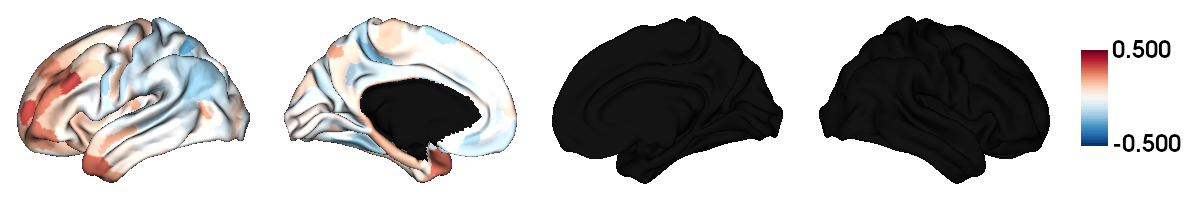

In [11]:
plot = map_to_labels(np.concatenate((-model_psy.x_loadings_[:,0],np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.5,0.5),
                   cmap = 'RdBu_r', filename = '../figures/hcp/cca_x_loading_psy.png')

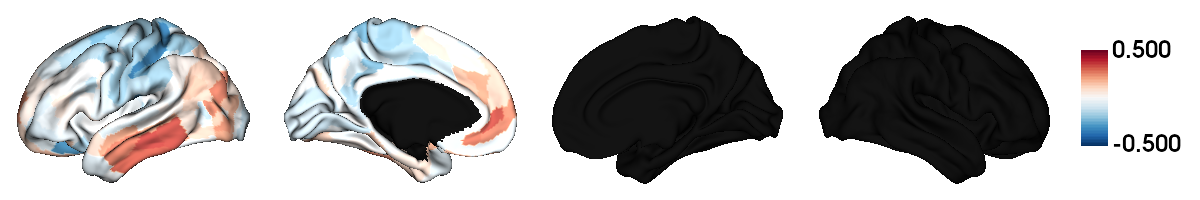

In [12]:
plot = map_to_labels(np.concatenate((-model_lan.x_loadings_[:,0],np.zeros(180))), glasser, mask=mask)
plot[plot==0]=np.nan

fp.plot_surface_lr(lh, rh, data = plot,
                   size = (1200, 200), color_range=(-0.5,0.5),
                   cmap = 'RdBu_r', filename = '../figures/hcp/cca_x_loading_lan.png')

In [13]:
import hcp_utils as hcp
from matplotlib.colors import ListedColormap
ca = np.array(pd.read_csv('../data/ca_glasser_network.csv', header = None))[:,0]
cmap = ListedColormap(np.vstack((list(hcp.ca_network['rgba'].values())))[1:])
color = ca[:180]

[(0.4152759332839856, 6.766746654666303e-09), 0.024]

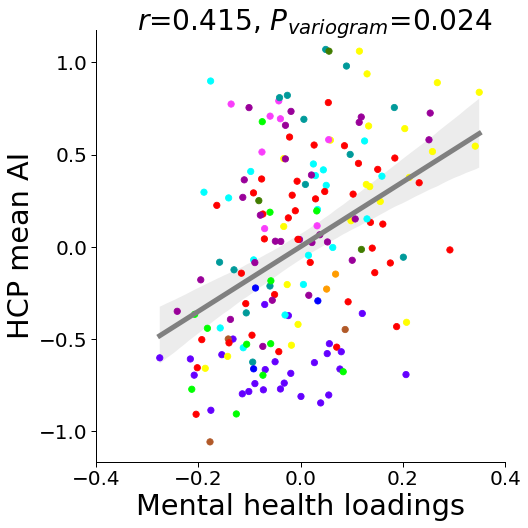

In [33]:
data = -model_psy.x_loadings_[:,0]
hcp_asy = np.loadtxt('../hcp/intensity_asy_mean.txt')
target = hcp_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel('Mental health loadings')
ax.set_ylabel('HCP mean AI')
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_psy_hcp_loading.png', dpi=300, transparent=True)
rp

[(0.3280678939573102, 6.927897617398019e-06), 0.034]

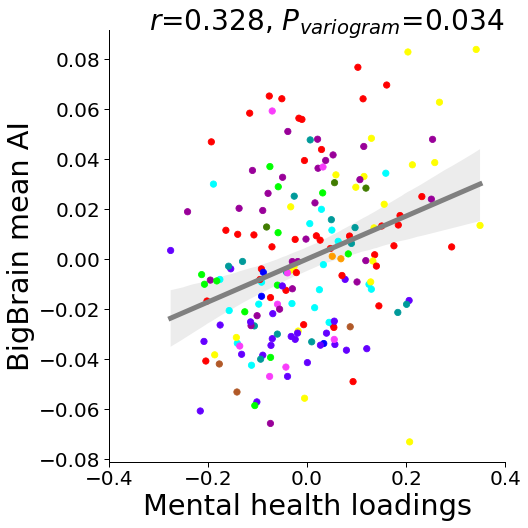

In [34]:
data = -model_psy.x_loadings_[:,0]
target = np.loadtxt('../bigbrain/mp_asy_mean.txt')
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel('Mental health loadings')
ax.set_ylabel('BigBrain mean AI')
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_psy_bigbrain_mean_loading.png', dpi=300, transparent=True)
rp

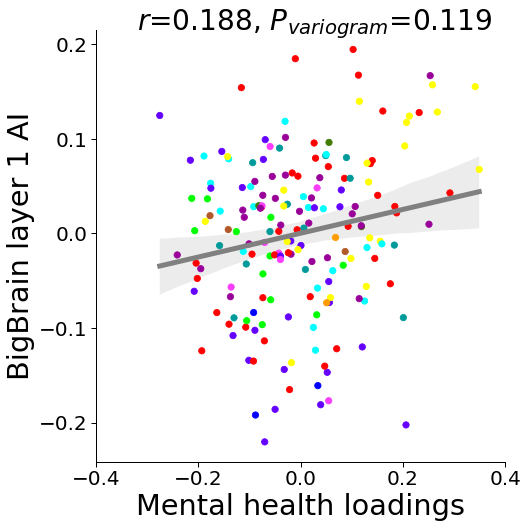

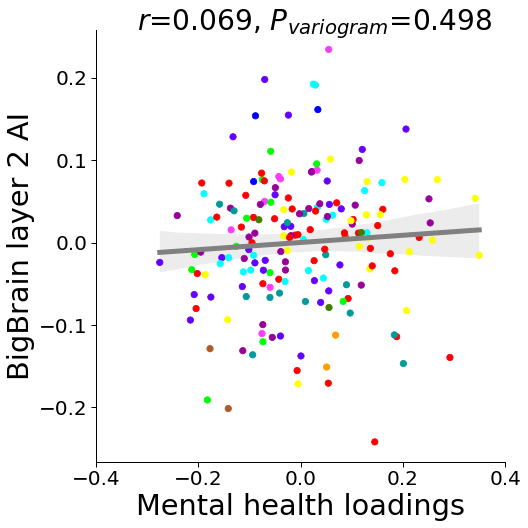

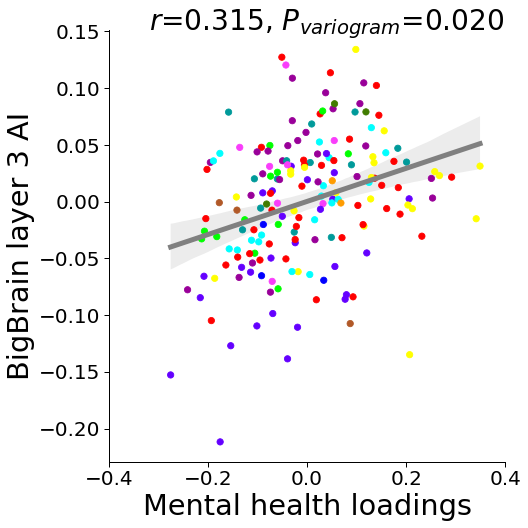

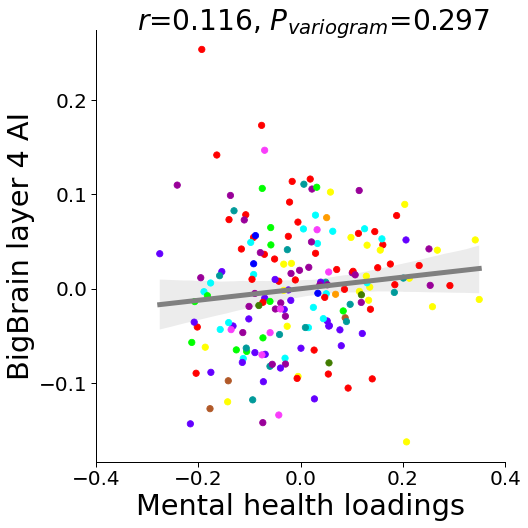

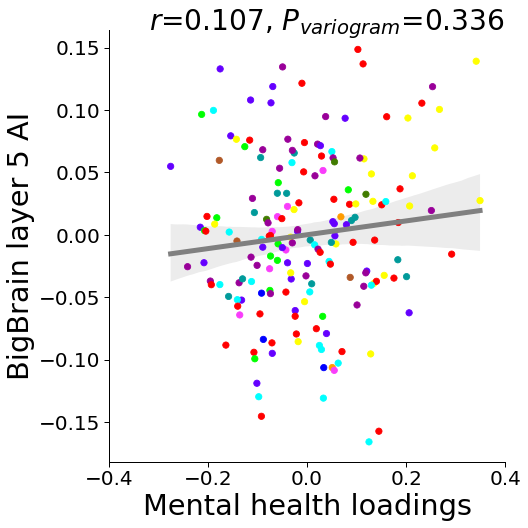

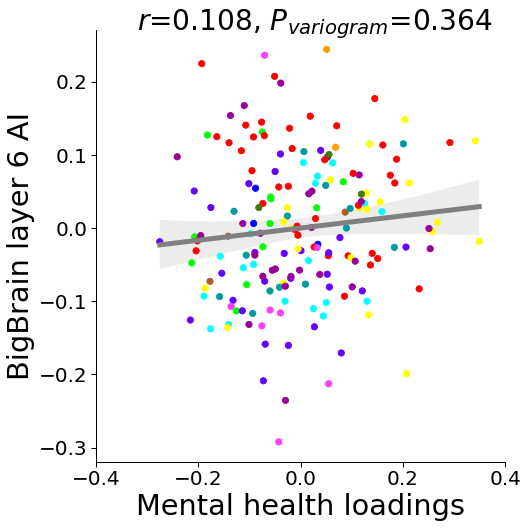

In [43]:
for i in range(6):
  data = -model_psy.x_loadings_[:,0]
  target = np.loadtxt('../bigbrain/mp_asy_layer_'+str(i+1)+'.txt')
  rp = fs.spin_pearson(data, target)
  color = np.array(list(hcp.ca_network['rgba'].values())[1:])
  sns.set_context("paper", font_scale = 3)
  fig, ax = plt.subplots(1, figsize=(8,8))
  sns.regplot(data, target, ax = ax, 
              scatter_kws={'s': 5, 'color': 'black'},
              line_kws={'lw': 5, 'color': 'grey'})
  ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
  ax.tick_params(axis='both', labelsize=20)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  #ax.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
  ax.set_xlabel('Mental health loadings')
  ax.set_ylabel('BigBrain layer '+str(i+1)+' AI')
  ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
          fontsize=28, c='black', transform=ax.transAxes)
  fig.tight_layout()
  plt.savefig('../figures/hcp/corr_psy_bigbrain_layer_'+str(i+1)+'_loading.png', dpi=300, transparent=True)

[(-0.08552419551211508, 0.25365089646635064), 0.639]

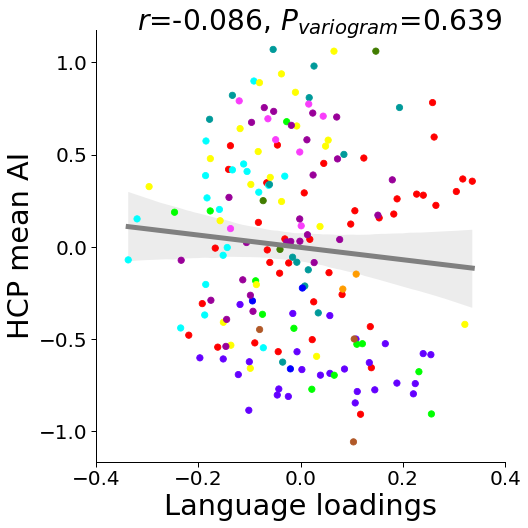

In [40]:
data = -model_lan.x_loadings_[:,0]
hcp_asy = np.loadtxt('../hcp/intensity_asy_mean.txt')
target = hcp_asy.copy()
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel('Language loadings')
ax.set_ylabel('HCP mean AI')
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_lan_hcp_loading.png', dpi=300, transparent=True)
rp

[(-0.00044057552790386983, 0.9953166350737429), 0.996]

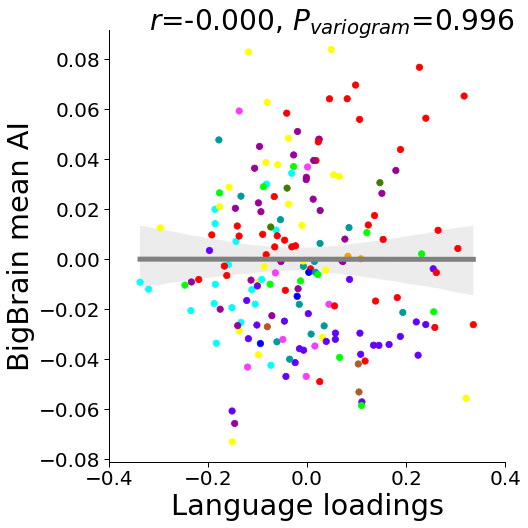

In [41]:
data = -model_lan.x_loadings_[:,0]
target = np.loadtxt('../bigbrain/mp_asy_mean.txt')
rp = fs.spin_pearson(data, target)
color = np.array(list(hcp.ca_network['rgba'].values())[1:])
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,8))
sns.regplot(data, target, ax = ax, 
            scatter_kws={'s': 5, 'color': 'black'},
            line_kws={'lw': 5, 'color': 'grey'})
ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
ax.tick_params(axis='both', labelsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
ax.set_xlabel('Language loadings')
ax.set_ylabel('BigBrain mean AI')
ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
        fontsize=28, c='black', transform=ax.transAxes)
fig.tight_layout()
plt.savefig('../figures/hcp/corr_lan_bigbrain_mean_loading.png', dpi=300, transparent=True)
rp

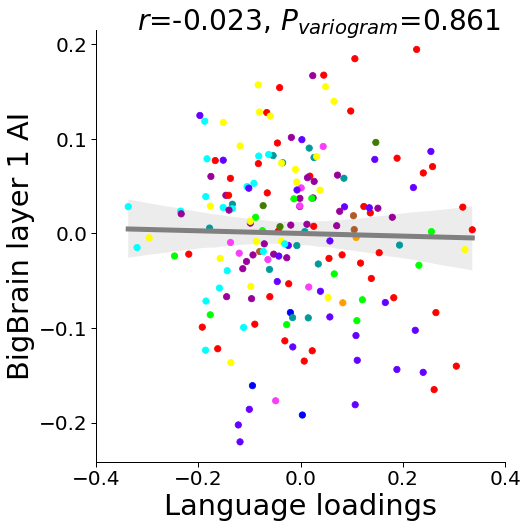

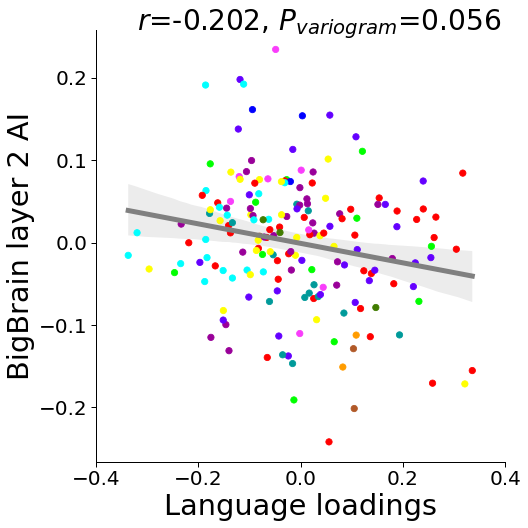

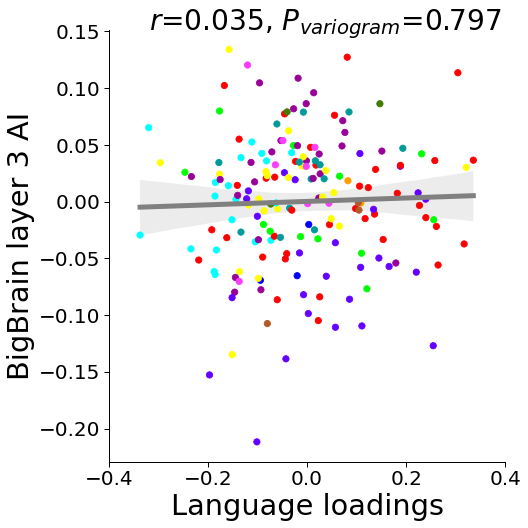

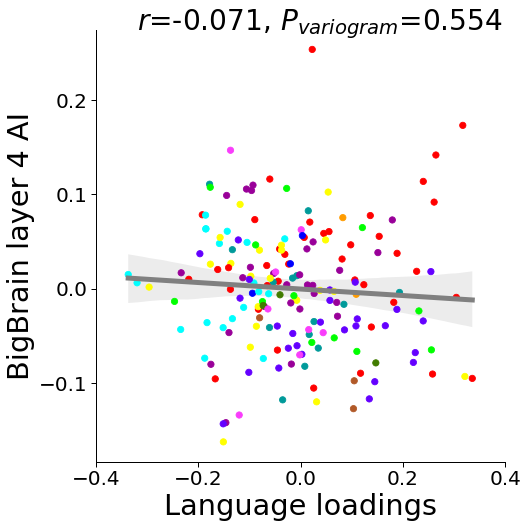

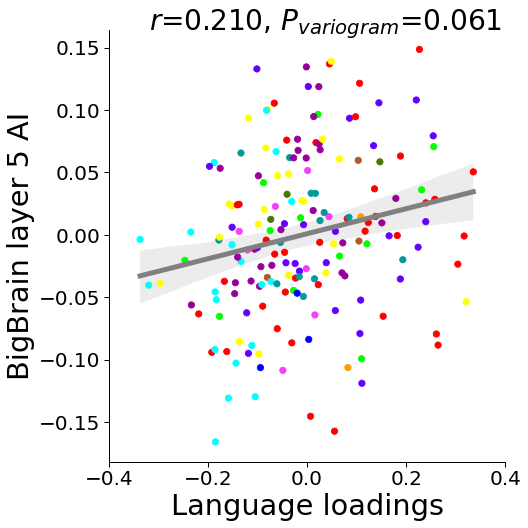

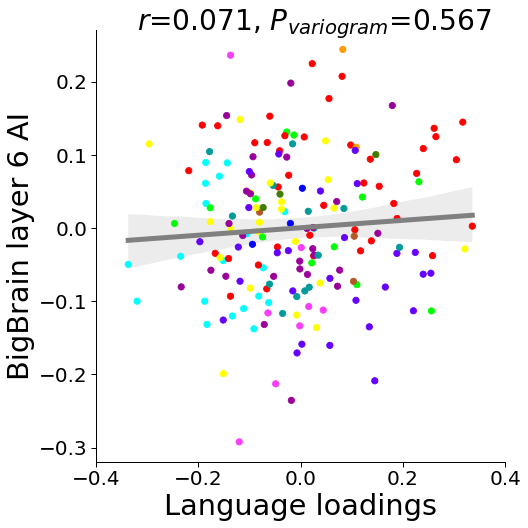

In [42]:
for i in range(6):
  data = -model_lan.x_loadings_[:,0]
  target = np.loadtxt('../bigbrain/mp_asy_layer_'+str(i+1)+'.txt')
  rp = fs.spin_pearson(data, target)
  color = np.array(list(hcp.ca_network['rgba'].values())[1:])
  sns.set_context("paper", font_scale = 3)
  fig, ax = plt.subplots(1, figsize=(8,8))
  sns.regplot(data, target, ax = ax, 
              scatter_kws={'s': 5, 'color': 'black'},
              line_kws={'lw': 5, 'color': 'grey'})
  ax.scatter(data, target,c=ca[:180], cmap=cmap, s=40)
  ax.tick_params(axis='both', labelsize=20)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  #ax.set_yticks([-1, -0.5, 0, 0.5, 1])
  ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
  ax.set_xlabel('Language loadings')
  ax.set_ylabel('BigBrain layer '+str(i+1)+' AI')
  ax.text(0.1, 1, '$\it{r}$=' + '%.3f'%(rp[0][0])+', $\it{P}$$_{variogram}$='+'%.3f'%(rp[1]), 
          fontsize=28, c='black', transform=ax.transAxes)
  fig.tight_layout()
  plt.savefig('../figures/hcp/corr_lan_bigbrain_layer_'+str(i+1)+'_loading.png', dpi=300, transparent=True)

## Resampling

In [17]:
# run 9 times from 0.1 to 0.9 of size
size=0.5
sample=100
x_train = [None] * sample
y_train = [None] * sample
x_test = [None] * sample
y_test = [None] * sample   
for sam in range(sample):
    x_train[sam], x_test[sam], y_train[sam], y_test[sam] = train_test_split(
      data_feature[mask_nan], np.array(pheno)[mask_nan], test_size=size, random_state=sam, stratify=mz_class[mask_nan])

In [18]:
train_lan_ml = [None] * sample
train_psy_ml = [None] * sample
test_lan_ml = [None] * sample
test_psy_ml = [None] * sample
lan_train = [None] * sample
psy_train = [None] * sample
lan_test = [None] * sample
psy_test = [None] * sample
for sam in range(sample):
    x = cov_rm(y_train[sam][:,:2], feature = x_train[sam])
    y_psy = y_train[sam][:,4:]
    y_lan = y_train[sam][:,2:4]

    train_psy_ml[sam] = CCA(n_components=1).fit(x, y_psy)
    x_t_train, y_t_train = train_psy_ml[sam].transform(x, y_psy)
    psy_train[sam] = np.concatenate((x_t_train, y_t_train),axis=1)
    train_lan_ml[sam] = CCA(n_components=1).fit(x, y_lan)
    x_t_train, y_t_train = train_lan_ml[sam].transform(x, y_lan)
    lan_train[sam] = np.concatenate((x_t_train, y_t_train),axis=1)

    x_new = cov_rm(y_test[sam][:,:2], feature = x_test[sam])
    y_psy = y_test[sam][:,4:]
    y_lan = y_test[sam][:,2:4]
    
    x_t_test, y_t_test = train_psy_ml[sam].transform(x_new, y_psy)
    psy_test[sam] = np.concatenate((x_t_test, y_t_test),axis=1)
    x_t_test, y_t_test = train_lan_ml[sam].transform(x_new, y_lan)
    lan_test[sam] = np.concatenate((x_t_test, y_t_test),axis=1)

    print(sam)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [19]:
rp_psy = [None] * sample
rp_lan = [None] * sample
hcp_asy = np.loadtxt('../hcp/intensity_asy_mean.txt')
target = hcp_asy.copy()
for i in range(sample):
  data = train_psy_ml[i].x_loadings_[:,0]
  rp_psy[i] = ss.pearsonr(data, target)
  data = train_lan_ml[i].x_loadings_[:,0]
  rp_lan[i] = ss.pearsonr(data, target)

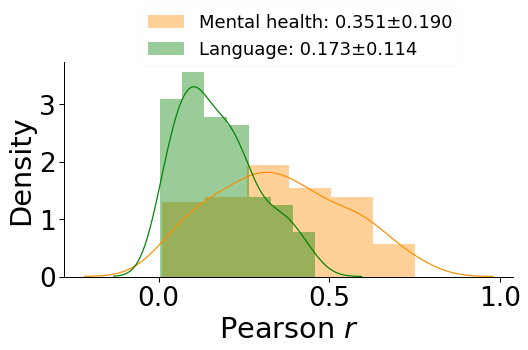

In [20]:
plot_psy = [abs(rp_psy[i][0]) for i in range(sample)]
plot_lan = [abs(rp_lan[i][0]) for i in range(sample)]
np.savetxt('../hcp/resampling_'+str(size)+'_corr_hcp_psy.txt', plot_psy)
np.savetxt('../hcp/resampling_'+str(size)+'_corr_hcp_lan.txt', plot_lan)

sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,6))
sns.distplot(plot_psy, ax=ax, label='Mental health: '+'%.3f'%np.mean(plot_psy)+'±'+'%.3f'%np.std(plot_psy), color='darkorange')
sns.distplot(plot_lan, ax=ax, label='Language: '+'%.3f'%np.mean(plot_lan)+'±'+'%.3f'%np.std(plot_lan), color='green')
plt.legend(bbox_to_anchor=(0.4,0.8,0.5,0.5), markerscale=0.5, scatterpoints=1, fontsize=18, framealpha=0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Pearson $\it{r}$')
plt.tight_layout()
plt.savefig('../figures/hcp/resampling_'+str(size)+'_corr_hcp.png', dpi=300, transparent=True)

In [21]:
psy_r = np.zeros((2,sample))
lan_r = np.zeros((2,sample))
for i in range(sample):
    psy_r[0,i] = np.corrcoef(psy_train[i].T)[0,1]
    psy_r[1,i] = np.corrcoef(psy_test[i].T)[0,1]
    lan_r[0,i] = np.corrcoef(lan_train[i].T)[0,1]
    lan_r[1,i] = np.corrcoef(lan_test[i].T)[0,1]

np.savetxt('../hcp/resampling_'+str(size)+'_cca_psy.txt', psy_r[0])
np.savetxt('../hcp/resampling_'+str(size)+'_cca_lan.txt', lan_r[0])

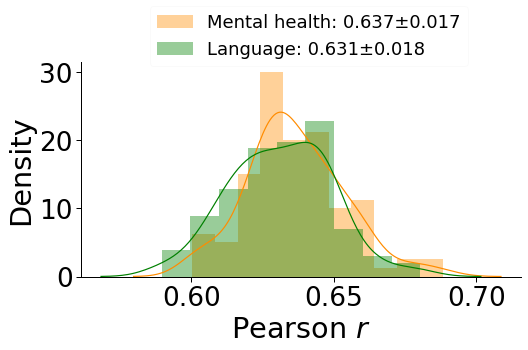

In [22]:
sns.set_context("paper", font_scale = 3)
fig, ax = plt.subplots(1, figsize=(8,6))
sns.distplot(psy_r[0], ax=ax, label='Mental health: '+'%.3f'%np.mean(psy_r[0])+'±'+'%.3f'%np.std(psy_r[0]), color='darkorange')
sns.distplot(lan_r[0], ax=ax, label='Language: '+'%.3f'%np.mean(lan_r[0])+'±'+'%.3f'%np.std(lan_r[0]), color='green')
plt.legend(bbox_to_anchor=(0.4,0.8,0.5,0.5), markerscale=0.5, scatterpoints=1, fontsize=18, framealpha=0.1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Pearson $\it{r}$')
plt.tight_layout()
plt.savefig('../figures/hcp/resampling_'+str(size)+'_cca.png', dpi=300, transparent=True)

### plot resampling size trend

In [23]:
np.array(range(9))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

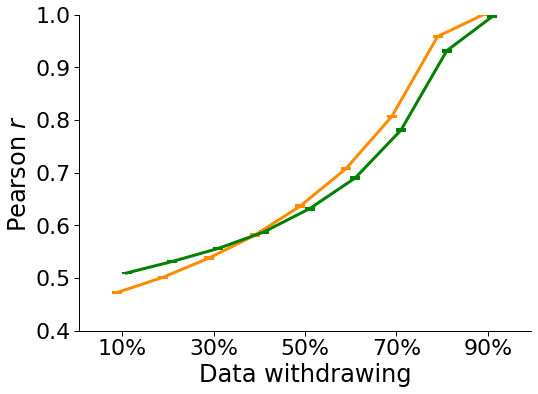

In [24]:
# cca

data = np.zeros((2,9,100))
list_s = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
for i in range(9):
  data[0,i] = np.loadtxt('../hcp/resampling_'+list_s[i]+'_cca_psy.txt')
  data[1,i] = np.loadtxt('../hcp/resampling_'+list_s[i]+'_cca_lan.txt') 

se_psy = [fs.se(data[0][i]) for i in range(9)]
se_lan = [fs.se(data[1][i]) for i in range(9)]
  
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(np.array(range(9))-0.1, data[0].mean(axis=1), color='darkorange', lw=3)
ax.plot(np.array(range(9))+0.1, data[1].mean(axis=1), color='green',lw=3)
ax.bar(np.array(range(9))-0.1, data[0].mean(axis=1), yerr=se_psy, color='darkorange', alpha=0,
       error_kw=dict(ecolor='darkorange', zorder=0, lw=3, capsize=5, capthick=2))
ax.bar(np.array(range(9))+0.1, data[1].mean(axis=1), yerr=se_lan, color='green', alpha=0,
       error_kw=dict(ecolor='green', zorder=0, lw=3, capsize=5, capthick=2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0,2,4,6,8])
ax.set_ylim(0.4,1)
ax.set_xticklabels(['10%','30%','50%','70%','90%'])
plt.ylabel('Pearson $\it{r}$')
plt.xlabel('Data withdrawing')
plt.tight_layout()
plt.savefig('../figures/hcp/resampling_cca.png', dpi=300, transparent=True)

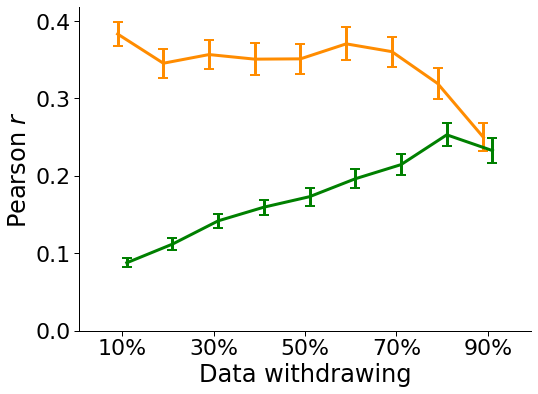

In [25]:
# brain loadings

data = np.zeros((2,9,100))
list_s = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
for i in range(9):
  data[0,i] = np.loadtxt('../hcp/resampling_'+list_s[i]+'_corr_hcp_psy.txt')
  data[1,i] = np.loadtxt('../hcp/resampling_'+list_s[i]+'_corr_hcp_lan.txt') 

se_psy = [fs.se(data[0][i]) for i in range(9)]
se_lan = [fs.se(data[1][i]) for i in range(9)]
       
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(1, figsize=(8,6))
ax.plot(np.array(range(9))-0.1, data[0].mean(axis=1), color='darkorange', lw=3)
ax.plot(np.array(range(9))+0.1, data[1].mean(axis=1), color='green',lw=3)
ax.bar(np.array(range(9))-0.1, data[0].mean(axis=1), yerr=se_psy, color='darkorange', alpha=0,
       error_kw=dict(ecolor='darkorange', zorder=0, lw=3, capsize=5, capthick=2))
ax.bar(np.array(range(9))+0.1, data[1].mean(axis=1), yerr=se_lan, color='green', alpha=0,
       error_kw=dict(ecolor='green', zorder=0, lw=3, capsize=5, capthick=2))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0,2,4,6,8])
#ax.set_ylim(0.4,1)
ax.set_xticklabels(['10%','30%','50%','70%','90%'])
plt.ylabel('Pearson $\it{r}$')
plt.xlabel('Data withdrawing')
plt.tight_layout()
plt.savefig('../figures/hcp/resampling_cca_corr.png', dpi=300, transparent=True)